In [1]:
import pandas as pd
import numpy as np
import os
import pymc3 as pm
from pymc3 import Model, sample, Normal, HalfCauchy, Uniform, model_to_graphviz
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score

In [2]:
os.chdir('/Users/mackenzyeleroy/Documents/MSDS/Bayes')

data from -
https://www.kaggle.com/wh0801/NBA-16-17-regular-season-shot-log

In [3]:
cleveland_file = 'shotlogCLE.csv'
houston_file = 'shotlogHOU.csv'


In [4]:
#Can run whole notebook for either file
df = pd.read_csv(houston_file)
#df = pd.read_csv(cleveland_file)

In [5]:
df['shoot player'].value_counts()

James Harden        1532
Eric Gordon         1014
Trevor Ariza         797
Ryan Anderson        773
Clint Capela         562
Patrick Beverley     543
Sam Dekker           429
Nene Hilario         397
Montrezl Harrell     345
Lou Williams         264
Corey Brewer         227
KJ McDaniels          68
Tyler Ennis           64
Bobby Brown           60
Troy Williams         44
Kyle Wiltjer          14
Chinanu Onuaku         7
Isaiah Taylor          7
Name: shoot player, dtype: int64

In [6]:
df

,self previous shot,player position,home game,location x,opponent previous shot,home team,shot type,points,away team,location y,time,date,shoot player,time from last shot,quarter,current shot outcome
0,NaN,PF,No,638.0,NaN,LAL,Jump Shot,3,HOU,193.0,0:16,2016-10-26,Ryan Anderson,NaN,1,SCORED
1,SCORED,SF,No,834.0,NaN,LAL,Fadeaway Jumper,2,HOU,296.0,0:49,2016-10-26,Trevor Ariza,33.0,1,MISSED
2,MISSED,SG,No,881.0,NaN,LAL,Layup,2,HOU,274.0,1:02,2016-10-26,James Harden,13.0,1,SCORED
3,SCORED,SG,No,765.0,SCORED,LAL,Step Back Jump Shot,2,HOU,286.0,1:33,2016-10-26,Eric Gordon,31.0,1,SCORED
4,SCORED,SG,No,873.0,SCORED,LAL,Driving Layup,2,HOU,263.0,1:45,2016-10-26,James Harden,12.0,1,SCORED
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7142,MISSED,PG,Yes,773.0,SCORED,HOU,Step Back Jump Shot,3,MIN,32.0,9:38,2017-04-12,Patrick Beverley,26.0,4,MISSED
7143,MISSED,F,Yes,895.0,SCORED,HOU,Layup,2,MIN,236.0,9:46,2017-04-12,Troy Williams,8.0,4,SCORED
7144,SCORED,SG,Yes,745.0,BLOCKED,HOU,Jump Shot,3,MIN,455.0,10:16,2017-04-12,Lou Williams,30.0,4,MISSED
7145,MISSED,SG,Yes,900.0,BLOCKED,HOU,Jump Shot,3,MIN,482.0,10:20,2017-04-12,Lou Williams,4.0,4,MISSED


In [7]:

df['date']= pd.to_datetime(df['date'])
df['location_x_feet'] = df['location x'] * (94/df['location x'].max())
df['location_y_feet'] = df['location y'] * (50/df['location y'].max())

df

,self previous shot,player position,home game,location x,opponent previous shot,home team,shot type,points,away team,location y,time,date,shoot player,time from last shot,quarter,current shot outcome,location_x_feet,location_y_feet
0,NaN,PF,No,638.0,NaN,LAL,Jump Shot,3,HOU,193.0,0:16,2016-10-26,Ryan Anderson,NaN,1,SCORED,65.186957,19.3
1,SCORED,SF,No,834.0,NaN,LAL,Fadeaway Jumper,2,HOU,296.0,0:49,2016-10-26,Trevor Ariza,33.0,1,MISSED,85.213043,29.6
2,MISSED,SG,No,881.0,NaN,LAL,Layup,2,HOU,274.0,1:02,2016-10-26,James Harden,13.0,1,SCORED,90.015217,27.4
3,SCORED,SG,No,765.0,SCORED,LAL,Step Back Jump Shot,2,HOU,286.0,1:33,2016-10-26,Eric Gordon,31.0,1,SCORED,78.163043,28.6
4,SCORED,SG,No,873.0,SCORED,LAL,Driving Layup,2,HOU,263.0,1:45,2016-10-26,James Harden,12.0,1,SCORED,89.197826,26.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7142,MISSED,PG,Yes,773.0,SCORED,HOU,Step Back Jump Shot,3,MIN,32.0,9:38,2017-04-12,Patrick Beverley,26.0,4,MISSED,78.980435,3.2
7143,MISSED,F,Yes,895.0,SCORED,HOU,Layup,2,MIN,236.0,9:46,2017-04-12,Troy Williams,8.0,4,SCORED,91.445652,23.6
7144,SCORED,SG,Yes,745.0,BLOCKED,HOU,Jump Shot,3,MIN,455.0,10:16,2017-04-12,Lou Williams,30.0,4,MISSED,76.119565,45.5
7145,MISSED,SG,Yes,900.0,BLOCKED,HOU,Jump Shot,3,MIN,482.0,10:20,2017-04-12,Lou Williams,4.0,4,MISSED,91.956522,48.2


In [8]:
#Need distance from hoop. Below are x and y coordinates for hoop
x_hoop_1 = 5.239014 
x_hoop_2 = 89.466238
y_hoop = 25

#calculate distance to each hoop
df['d1'] = np.sqrt(((df.location_x_feet - x_hoop_1)**2) + ((df.location_y_feet - y_hoop)**2))
df['d2'] = np.sqrt(((df.location_x_feet - x_hoop_2)**2) + ((df.location_y_feet - y_hoop)**2))

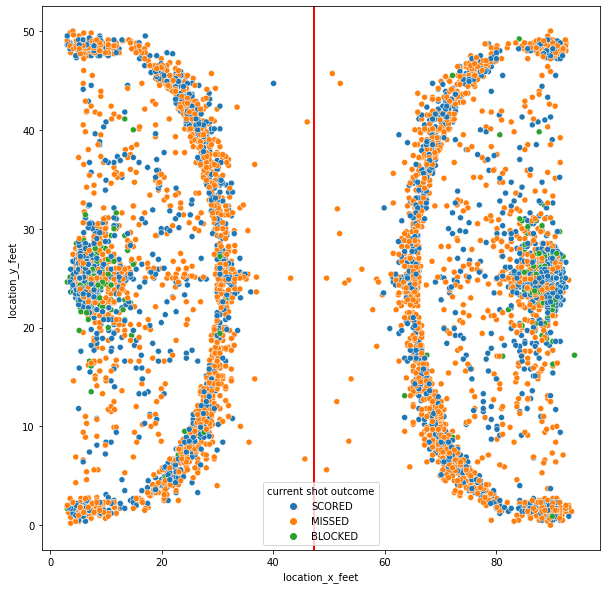

In [9]:
#
df_home = df[df['home team'] == 'CLE' ]
df_away = df[df['away team'] == 'CLE' ]

#Visualizaion of all shots made, missed, and blocked
plt.figure(figsize = (10,10))
sns.scatterplot(data = df, x = 'location_x_feet', y = 'location_y_feet', hue = 'current shot outcome')
plt.axvline(linewidth=2, color='r', x = ((x_hoop_1 + x_hoop_2)/2))

In [10]:
#take minimum of two hoop distances
df['distance'] = round(df[['d1','d2']].min(axis=1), 3)

In [11]:
#Check dunks are giving a distance of 0 or close to 0
df[df['shot type'] == 'Dunk']

,self previous shot,player position,home game,location x,opponent previous shot,home team,shot type,points,away team,location y,...,date,shoot player,time from last shot,quarter,current shot outcome,location_x_feet,location_y_feet,d1,d2,distance
9,MISSED,PF,No,888.0,SCORED,LAL,Dunk,2,HOU,250.0,...,2016-10-26,Nene Hilario,22.0,1,SCORED,90.730435,25.0,85.491421,1.264197,1.264
95,SCORED,SF,No,888.0,MISSED,DAL,Dunk,2,HOU,250.0,...,2016-10-28,Trevor Ariza,33.0,1,SCORED,90.730435,25.0,85.491421,1.264197,1.264
155,MISSED,PF,No,52.0,SCORED,DAL,Dunk,2,HOU,250.0,...,2016-10-28,Montrezl Harrell,2.0,4,SCORED,5.313043,25.0,0.074029,84.153195,0.074
186,MISSED,C,Yes,52.0,MISSED,HOU,Dunk,2,DAL,250.0,...,2016-10-30,Clint Capela,33.0,2,MISSED,5.313043,25.0,0.074029,84.153195,0.074
238,SCORED,C,No,888.0,SCORED,CLE,Dunk,2,HOU,250.0,...,2016-11-01,Clint Capela,33.0,1,SCORED,90.730435,25.0,85.491421,1.264197,1.264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6918,MISSED,PF,No,888.0,SCORED,SAC,Dunk,2,HOU,250.0,...,2017-04-09,Montrezl Harrell,29.0,2,SCORED,90.730435,25.0,85.491421,1.264197,1.264
6938,SCORED,C,No,52.0,MISSED,SAC,Dunk,2,HOU,250.0,...,2017-04-09,Clint Capela,18.0,3,SCORED,5.313043,25.0,0.074029,84.153195,0.074
7027,MISSED,PF,No,52.0,MISSED,LAC,Dunk,2,HOU,250.0,...,2017-04-10,Montrezl Harrell,NaN,4,SCORED,5.313043,25.0,0.074029,84.153195,0.074
7104,SCORED,C,Yes,888.0,SCORED,HOU,Dunk,2,MIN,250.0,...,2017-04-12,Clint Capela,29.0,3,SCORED,90.730435,25.0,85.491421,1.264197,1.264


In [12]:
df

,self previous shot,player position,home game,location x,opponent previous shot,home team,shot type,points,away team,location y,...,date,shoot player,time from last shot,quarter,current shot outcome,location_x_feet,location_y_feet,d1,d2,distance
0,NaN,PF,No,638.0,NaN,LAL,Jump Shot,3,HOU,193.0,...,2016-10-26,Ryan Anderson,NaN,1,SCORED,65.186957,19.3,60.218318,24.939397,24.939
1,SCORED,SF,No,834.0,NaN,LAL,Fadeaway Jumper,2,HOU,296.0,...,2016-10-26,Trevor Ariza,33.0,1,MISSED,85.213043,29.6,80.106213,6.264955,6.265
2,MISSED,SG,No,881.0,NaN,LAL,Layup,2,HOU,274.0,...,2016-10-26,James Harden,13.0,1,SCORED,90.015217,27.4,84.810168,2.461987,2.462
3,SCORED,SG,No,765.0,SCORED,LAL,Step Back Jump Shot,2,HOU,286.0,...,2016-10-26,Eric Gordon,31.0,1,SCORED,78.163043,28.6,73.012835,11.862639,11.863
4,SCORED,SG,No,873.0,SCORED,LAL,Driving Layup,2,HOU,263.0,...,2016-10-26,James Harden,12.0,1,SCORED,89.197826,26.3,83.968876,1.327420,1.327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7142,MISSED,PG,Yes,773.0,SCORED,HOU,Step Back Jump Shot,3,MIN,32.0,...,2017-04-12,Patrick Beverley,26.0,4,MISSED,78.980435,3.2,76.896275,24.190743,24.191
7143,MISSED,F,Yes,895.0,SCORED,HOU,Layup,2,MIN,236.0,...,2017-04-12,Troy Williams,8.0,4,SCORED,91.445652,23.6,86.218005,2.424475,2.424
7144,SCORED,SG,Yes,745.0,BLOCKED,HOU,Jump Shot,3,MIN,455.0,...,2017-04-12,Lou Williams,30.0,4,MISSED,76.119565,45.5,73.785517,24.461882,24.462
7145,MISSED,SG,Yes,900.0,BLOCKED,HOU,Jump Shot,3,MIN,482.0,...,2017-04-12,Lou Williams,4.0,4,MISSED,91.956522,48.2,89.767289,23.333271,23.333


/Users/mackenzyeleroy/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


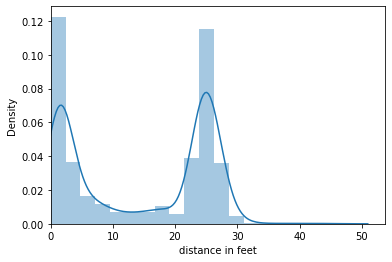

In [13]:
#Plot all shots taken. Note: nba 3 point line ~ 21 feet
x = df.distance
x = pd.Series(x, name="distance in feet")
ax = sns.distplot(x).set(xlim = 0)
#sns.histplot(data=df2, x="distance", hue = 'current shot outcome')

In [14]:
made_shots = df[df['current shot outcome'] == 'SCORED']
missed_shots = df[df['current shot outcome'] == 'MISSED']
blocked_shots = df[df['current shot outcome'] == 'BLOCKED']

In [15]:
made_shots['shot type'].value_counts()

Jump Shot                          1104
Driving Layup                       357
Layup                               220
Cutting Layup Shot                  153
Pullup Jump Shot                    139
Step Back Jump Shot                 127
Dunk                                125
Cutting Dunk Shot                   123
Alley Oop Dunk                      109
Running Layup                        98
Driving Finger Roll Layup            62
Driving Dunk                         56
Tip Layup Shot                       55
Driving Floating Jump Shot           53
Putback Layup                        51
Floating Jump Shot                   46
Running Dunk                         44
Reverse Layup                        43
Alley Oop Layup                      32
Running Jump Shot                    30
Fadeaway Jumper                      30
Driving Reverse Layup                27
Turnaround Hook Shot                 27
Jump Bank Shot                       23
Hook Shot                            23


In [16]:
missed_shots

,self previous shot,player position,home game,location x,opponent previous shot,home team,shot type,points,away team,location y,...,date,shoot player,time from last shot,quarter,current shot outcome,location_x_feet,location_y_feet,d1,d2,distance
1,SCORED,SF,No,834.0,NaN,LAL,Fadeaway Jumper,2,HOU,296.0,...,2016-10-26,Trevor Ariza,33.0,1,MISSED,85.213043,29.6,80.106213,6.264955,6.265
7,SCORED,PF,No,858.0,SCORED,LAL,Cutting Layup Shot,2,HOU,260.0,...,2016-10-26,Nene Hilario,67.0,1,MISSED,87.665217,26.0,82.432269,2.060018,2.060
8,MISSED,PF,No,837.0,SCORED,LAL,Jump Shot,2,HOU,359.0,...,2016-10-26,Nene Hilario,37.0,1,MISSED,85.519565,35.9,81.017140,11.592507,11.593
11,SCORED,SG,No,NaN,SCORED,LAL,Step Back Jump Shot,3,HOU,NaN,...,2016-10-26,James Harden,66.0,1,MISSED,NaN,NaN,NaN,NaN,NaN
14,SCORED,SG,No,868.0,MISSED,LAL,Driving Layup,2,HOU,237.0,...,2016-10-26,James Harden,19.0,1,MISSED,88.686957,23.7,83.458068,1.515678,1.516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7141,MISSED,SG,Yes,691.0,SCORED,HOU,Pullup Jump Shot,3,MIN,89.0,...,2017-04-12,James Harden,66.0,4,MISSED,70.602174,8.9,67.316808,24.800462,24.800
7142,MISSED,PG,Yes,773.0,SCORED,HOU,Step Back Jump Shot,3,MIN,32.0,...,2017-04-12,Patrick Beverley,26.0,4,MISSED,78.980435,3.2,76.896275,24.190743,24.191
7144,SCORED,SG,Yes,745.0,BLOCKED,HOU,Jump Shot,3,MIN,455.0,...,2017-04-12,Lou Williams,30.0,4,MISSED,76.119565,45.5,73.785517,24.461882,24.462
7145,MISSED,SG,Yes,900.0,BLOCKED,HOU,Jump Shot,3,MIN,482.0,...,2017-04-12,Lou Williams,4.0,4,MISSED,91.956522,48.2,89.767289,23.333271,23.333


In [17]:
blocked_shots

,self previous shot,player position,home game,location x,opponent previous shot,home team,shot type,points,away team,location y,...,date,shoot player,time from last shot,quarter,current shot outcome,location_x_feet,location_y_feet,d1,d2,distance
31,SCORED,PF,No,832.0,MISSED,LAL,Jump Shot,2,HOU,279.0,...,2016-10-26,Ryan Anderson,36.0,2,BLOCKED,85.008696,27.9,79.822379,5.317865,5.318
55,MISSED,C,No,88.0,MISSED,LAL,Jump Shot,2,HOU,250.0,...,2016-10-26,Clint Capela,28.0,3,BLOCKED,8.991304,25.0,3.752290,80.474934,3.752
75,MISSED,C,No,67.0,MISSED,LAL,Layup,2,HOU,255.0,...,2016-10-26,Clint Capela,36.0,4,BLOCKED,6.845652,25.5,1.682643,82.622099,1.683
79,MISSED,SG,No,72.0,SCORED,LAL,Driving Layup,2,HOU,219.0,...,2016-10-26,James Harden,63.0,4,BLOCKED,7.356522,21.9,3.754176,82.168215,3.754
122,SCORED,SG,No,882.0,SCORED,DAL,Driving Floating Jump Shot,2,HOU,236.0,...,2016-10-28,James Harden,33.0,2,BLOCKED,90.117391,23.6,84.889922,1.544021,1.544
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6929,SCORED,SG,No,64.0,MISSED,SAC,Driving Layup,2,HOU,215.0,...,2017-04-09,James Harden,27.0,3,BLOCKED,6.539130,21.5,3.733671,83.000935,3.734
6936,MISSED,SG,No,298.0,MISSED,SAC,Jump Shot,3,HOU,194.0,...,2017-04-09,James Harden,23.0,3,BLOCKED,30.447826,19.4,25.823327,59.283496,25.823
7070,SCORED,PF,Yes,58.0,SCORED,HOU,Cutting Layup Shot,2,MIN,231.0,...,2017-04-12,Nene Hilario,34.0,1,BLOCKED,5.926087,23.1,2.020413,83.561755,2.020
7125,MISSED,PG,Yes,850.0,SCORED,HOU,Driving Layup,2,MIN,237.0,...,2017-04-12,Patrick Beverley,48.0,4,BLOCKED,86.847826,23.7,81.619166,2.923368,2.923


/Users/mackenzyeleroy/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


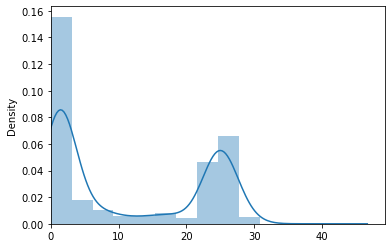

In [18]:
#Plot all made plots
sns.distplot(made_shots[['distance']], hist=True, rug=False).set(xlim=(0))
plt.show()

/Users/mackenzyeleroy/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[(0.0, 54.0227291764834)]

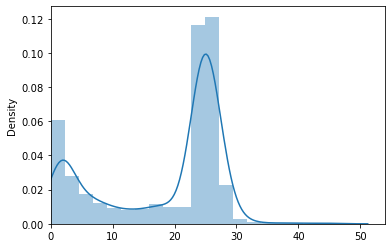

In [19]:
#plot all missed shots
sns.distplot(missed_shots[['distance']], hist=True, rug=False).set(xlim=(0))

/Users/mackenzyeleroy/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[(0.0, 35.939500547754584)]

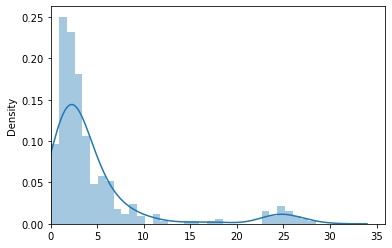

In [20]:
#plot all blocked shots
sns.distplot(blocked_shots[['distance']], hist=True, rug=False).set(xlim=(0))

### Set up data for actually running models

In [21]:
#Set up binary made/not made variable
df['made_shot'] = (df['current shot outcome'] == 'SCORED').astype(int)

In [22]:
#remove NA's
dfna = df[df.distance.isna()]
dfna

,self previous shot,player position,home game,location x,opponent previous shot,home team,shot type,points,away team,location y,...,shoot player,time from last shot,quarter,current shot outcome,location_x_feet,location_y_feet,d1,d2,distance,made_shot
11,SCORED,SG,No,NaN,SCORED,LAL,Step Back Jump Shot,3,HOU,NaN,...,James Harden,66.0,1,MISSED,NaN,NaN,NaN,NaN,NaN,0
3221,MISSED,SG,No,NaN,SCORED,ORL,Step Back Jump Shot,3,HOU,NaN,...,James Harden,58.0,1,MISSED,NaN,NaN,NaN,NaN,NaN,0
3245,MISSED,PG,No,NaN,MISSED,ORL,Jump Shot,3,HOU,NaN,...,Patrick Beverley,4.0,2,SCORED,NaN,NaN,NaN,NaN,NaN,1
4097,MISSED,SF,No,NaN,SCORED,MIL,Jump Shot,3,HOU,NaN,...,Trevor Ariza,29.0,1,SCORED,NaN,NaN,NaN,NaN,NaN,1
5376,MISSED,PG,No,NaN,MISSED,LAC,Jump Shot,3,HOU,NaN,...,Patrick Beverley,10.0,4,MISSED,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6708,SCORED,PG,No,NaN,SCORED,PHX,Driving Floating Jump Shot,2,HOU,NaN,...,Patrick Beverley,31.0,4,SCORED,NaN,NaN,NaN,NaN,NaN,1
6709,SCORED,PF,No,NaN,MISSED,PHX,Dunk,2,HOU,NaN,...,Nene Hilario,50.0,4,MISSED,NaN,NaN,NaN,NaN,NaN,0
6710,MISSED,PG,No,NaN,MISSED,PHX,Jump Bank Shot,3,HOU,NaN,...,Patrick Beverley,21.0,4,MISSED,NaN,NaN,NaN,NaN,NaN,0
6711,MISSED,PF,No,NaN,MISSED,PHX,Dunk,2,HOU,NaN,...,Nene Hilario,2.0,4,SCORED,NaN,NaN,NaN,NaN,NaN,1


In [23]:
#remove na's
df = df[df.distance.notna()]

In [24]:
#remove players with less than 25 shots taken
[df['shoot player'].value_counts() > 25]

[James Harden         True
 Eric Gordon          True
 Trevor Ariza         True
 Ryan Anderson        True
 Clint Capela         True
 Patrick Beverley     True
 Sam Dekker           True
 Nene Hilario         True
 Montrezl Harrell     True
 Lou Williams         True
 Corey Brewer         True
 KJ McDaniels         True
 Tyler Ennis          True
 Bobby Brown          True
 Troy Williams        True
 Kyle Wiltjer        False
 Chinanu Onuaku      False
 Isaiah Taylor       False
 Name: shoot player, dtype: bool]

In [25]:
#check
df = df.groupby('shoot player').filter(lambda x : len(x)>25)
[df['shoot player'].value_counts() > 25]

[James Harden        True
 Eric Gordon         True
 Trevor Ariza        True
 Ryan Anderson       True
 Clint Capela        True
 Patrick Beverley    True
 Sam Dekker          True
 Nene Hilario        True
 Montrezl Harrell    True
 Lou Williams        True
 Corey Brewer        True
 KJ McDaniels        True
 Tyler Ennis         True
 Bobby Brown         True
 Troy Williams       True
 Name: shoot player, dtype: bool]

In [26]:
#Set up training/testing split
test_df = df.sample(1000, random_state = 4200)
train_df = df.drop(test_df.index)

#Sort each by distance
train_df = train_df.sort_values(by= ['distance'])
test_df = test_df.sort_values(by= ['distance'])

In [27]:
train_df

,self previous shot,player position,home game,location x,opponent previous shot,home team,shot type,points,away team,location y,...,shoot player,time from last shot,quarter,current shot outcome,location_x_feet,location_y_feet,d1,d2,distance,made_shot
4901,MISSED,SF,Yes,876.0,SCORED,HOU,Driving Finger Roll Layup,2,PHX,250.0,...,Trevor Ariza,53.0,3,SCORED,89.504348,25.0,84.265334,0.038110,0.038,1
6224,SCORED,SF,Yes,876.0,MISSED,HOU,Driving Layup,2,NOP,250.0,...,Trevor Ariza,28.0,3,SCORED,89.504348,25.0,84.265334,0.038110,0.038,1
4274,MISSED,C,No,875.0,SCORED,PHI,Layup,2,HOU,250.0,...,Clint Capela,4.0,2,MISSED,89.402174,25.0,84.163160,0.064064,0.064,0
4290,SCORED,SG,No,52.0,SCORED,PHI,Driving Dunk,2,HOU,250.0,...,James Harden,19.0,3,SCORED,5.313043,25.0,0.074029,84.153195,0.074,1
4501,SCORED,C,Yes,52.0,SCORED,HOU,Dunk,2,ATL,250.0,...,Clint Capela,29.0,1,SCORED,5.313043,25.0,0.074029,84.153195,0.074,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6306,SCORED,SF,Yes,451.0,BLOCKED,HOU,Jump Shot,3,OKL,408.0,...,Trevor Ariza,45.0,2,MISSED,46.080435,40.8,43.791114,46.173238,43.791,0
3793,SCORED,SF,No,495.0,SCORED,MIA,Jump Shot,3,HOU,457.0,...,Corey Brewer,45.0,3,MISSED,50.576087,45.7,49.839143,44.056031,44.056,0
1403,MISSED,SG,No,485.0,MISSED,POR,Jump Shot,3,HOU,56.0,...,James Harden,26.0,2,MISSED,49.554348,5.6,48.375705,44.377010,44.377,0
4514,MISSED,SG,Yes,447.0,MISSED,HOU,Jump Shot,3,ATL,67.0,...,James Harden,25.0,1,MISSED,45.671739,6.7,44.381249,47.464177,44.381,0


In [28]:
test_df

,self previous shot,player position,home game,location x,opponent previous shot,home team,shot type,points,away team,location y,...,shoot player,time from last shot,quarter,current shot outcome,location_x_feet,location_y_feet,d1,d2,distance,made_shot
6052,MISSED,C,No,52.0,MISSED,DEN,Alley Oop Dunk,2,HOU,250.0,...,Clint Capela,25.0,3,SCORED,5.313043,25.0,0.074029,84.153195,0.074,1
2267,MISSED,C,Yes,52.0,SCORED,HOU,Dunk,2,NOP,250.0,...,Clint Capela,69.0,2,SCORED,5.313043,25.0,0.074029,84.153195,0.074,1
155,MISSED,PF,No,52.0,SCORED,DAL,Dunk,2,HOU,250.0,...,Montrezl Harrell,2.0,4,SCORED,5.313043,25.0,0.074029,84.153195,0.074,1
2716,SCORED,PF,Yes,52.0,MISSED,HOU,Driving Reverse Dunk Shot,2,PHX,250.0,...,Nene Hilario,33.0,1,SCORED,5.313043,25.0,0.074029,84.153195,0.074,1
4367,MISSED,PF,No,52.0,MISSED,IND,Driving Dunk,2,HOU,250.0,...,Montrezl Harrell,NaN,3,SCORED,5.313043,25.0,0.074029,84.153195,0.074,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4392,SCORED,PF,No,274.0,SCORED,IND,Jump Shot,3,HOU,58.0,...,Ryan Anderson,40.0,4,MISSED,27.995652,5.8,29.774227,64.399324,29.774,0
6945,MISSED,SG,No,339.0,SCORED,SAC,Jump Shot,3,HOU,324.0,...,James Harden,41.0,3,MISSED,34.636957,32.4,30.314997,55.326396,30.315,0
578,MISSED,PF,No,320.0,SCORED,WAS,Jump Shot,3,HOU,108.0,...,Ryan Anderson,21.0,4,SCORED,32.695652,10.8,30.911276,58.519564,30.911,1
6474,SCORED,SG,No,573.0,SCORED,POR,Jump Shot,3,HOU,181.0,...,James Harden,26.0,2,MISSED,58.545652,18.1,53.751350,31.681108,31.681,0


In [29]:
#check both players in each 
len(train_df['shoot player'].value_counts()) == len(test_df['shoot player'].value_counts())

True

In [30]:
#will use for predictions later
test_distance = test_df['distance']
test_made_shot = test_df['made_shot']

In [31]:
#Helper fucntion for plotting later
def logistic(x):
    return 1/ (1 + np.exp(-x))


In [32]:
#set up data for models
distance = np.array(train_df['distance'])
distances = train_df['distance'].unique()
made_shot = np.array(train_df['made_shot'])

## Pooled Model

In [33]:
#Set up Model
with Model() as pooled_model:
    
    observed_data = pm.Data('observed_data', made_shot)
    distance_data = pm.Data('distance_data', distance)
    
    beta = pm.Normal('beta', 0, sd=1e5, shape=2)

    theta = pm.Deterministic('theta', pm.invlogit(beta[0] + beta[1] * distance_data))    

    y = pm.Bernoulli('y', theta, observed=observed_data)

#pm.model_to_graphviz(pooled_model)

Just HMC

In [34]:
with pooled_model:
   pooled_trace = pm.sample(1000, cores = 4, tune=1000)
   pooled_idata1 = az.from_pymc3(pooled_trace)


<ipython-input-34-4a08b80640c9>:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  pooled_trace = pm.sample(1000, cores = 4, tune=1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.
The acceptance probability does not match the target. It is 0.8820677870917187, but should be close to 0.8. Try to increase the number of tuning steps.


Just ADVI

In [35]:
with pooled_model:
   approx1 = pm.fit(30000, method = 'advi')
   pooling_fit = approx1.sample(10000)
   pooled_idata2 = az.from_pymc3(pooling_fit)

Finished [100%]: Average Loss = 4,004.7


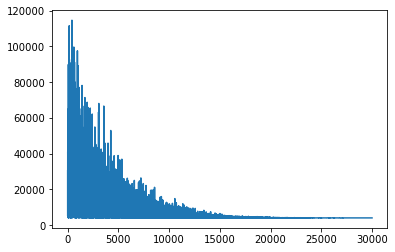

In [36]:
#ELBO Plot - see nice convergence
plt.plot(approx1.hist);

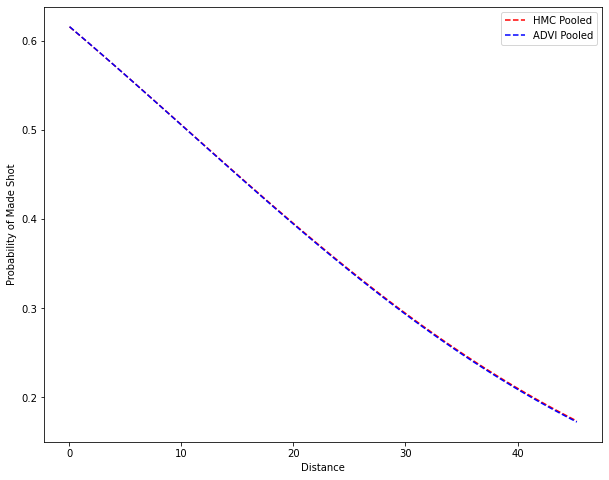

In [37]:
# Plot of the pooled model (HMC & ADVI)
b0, m0 = pooled_trace['beta'].mean(axis=0)
b01, m01 = pooling_fit['beta'].mean(axis=0)
plt.figure(figsize = (10,8))

xvals = np.linspace(min(distance), max(distance))
plt.plot(xvals, logistic(m0*xvals+b0), 'r--', label = 'HMC Pooled');
plt.plot(xvals, logistic(m01*xvals+b01), 'b--', label = 'ADVI Pooled');
plt.xlabel("Distance")
plt.ylabel("Probability of Made Shot")
plt.legend()

## Unpooled

In [38]:
#set up with players data for unpooled and hierarchical model
uniq_players_train = train_df['shoot player'].unique()
players_train = len(uniq_players_train)
player_train = np.array(train_df['shoot player'])
player_lookup_train = dict(zip(uniq_players_train , range(len(uniq_players_train))))
player_train = train_df['player'] = train_df['shoot player'].replace(player_lookup_train).values

In [39]:
#Set up unpooled model
with Model() as unpooled_model:
    
    observed_data = pm.Data('observed_data', made_shot)
    distance_data = pm.Data('distance_data', distance)
    player = pm.Data('player', player_train)

    beta0 = pm.Normal('beta0', 0, sd=1e5, shape = players_train)
    beta1 = pm.Normal('beta1', 0, sd=1e5, shape = players_train)
    
    theta = pm.Deterministic('theta', pm.invlogit(beta0[player] + beta1[player]*distance_data))  


    
    y = pm.Bernoulli('y', theta, observed=observed_data)

#pm.model_to_graphviz(unpooled_model)

In [40]:
#Run MCMC and ADVI

#Google colab doesn't like running these, but my machine was fine

with unpooled_model:
   unpooled_trace = pm.sample(1000, cores = 4, tune=1000)

<ipython-input-40-acab00619ade>:6: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  unpooled_trace = pm.sample(1000, cores = 4, tune=1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta1, beta0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.


In [41]:

with unpooled_model:
   approx2 = pm.fit(50000, method = 'advi')
   unpooled_fit = approx2.sample(5000)
   unpooled_idata2 = az.from_pymc3(unpooled_fit)

Finished [100%]: Average Loss = 4,359.5


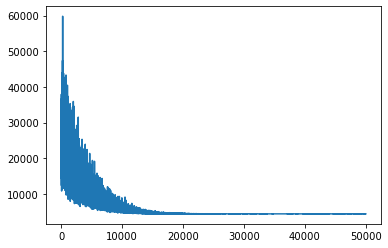

In [42]:
#ELBO Plot - nice convergence
plt.plot(approx2.hist);

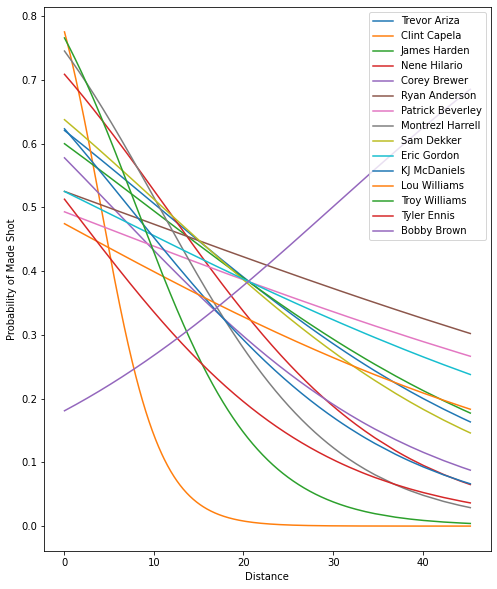

In [43]:
#HMC
import numpy as np
Beta0 = np.mean(unpooled_trace['beta0'], axis = 0)
Beta1 = np.mean(unpooled_trace['beta1'], axis = 0)
plt.figure(figsize = (8,10))
count = 0
for x in range(len(Beta0)):  
    beta0i = Beta0[x]
    beta1i = Beta1[x]
    label = list(player_lookup_train.keys())[list(player_lookup_train.values()).index(count)]
    plt.plot(distance, logistic(beta0i + beta1i*distance), label = label)
    count +=1

plt.xlabel("Distance")
plt.ylabel("Probability of Made Shot")
plt.legend()

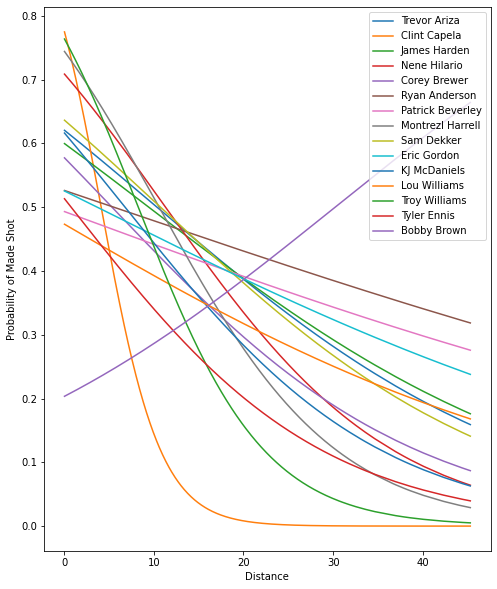

In [44]:
#AVDI
Beta0 = np.mean(unpooled_fit['beta0'], axis = 0)
Beta1 = np.mean(unpooled_fit['beta1'], axis = 0)
plt.figure(figsize = (8,10))
count = 0
for x in range(len(Beta0)):  
    beta0i = Beta0[x]
    beta1i = Beta1[x]
    label = list(player_lookup_train.keys())[list(player_lookup_train.values()).index(count)]
    plt.plot(distance, logistic(beta0i + beta1i*distance), label = label)
    count +=1

plt.xlabel("Distance")
plt.ylabel("Probability of Made Shot")
plt.legend()

## Hierarchical Model

In [45]:
with Model() as hierarchical_model:
    
    # Set up data
    observed_data = pm.Data('observed_data', made_shot)
    distance_data = pm.Data('distance_data', distance)
    player = pm.Data('player', player_train)

    # Priors
    mu_a = pm.Normal('mu_a', mu=0., sd=1e5)
    sigma_a = pm.HalfCauchy("sigma_a", 1e5)
    mu_b = pm.Normal('mu_b', mu=0., sd=1e5)
    sigma_b =  pm.HalfCauchy('sigma_b', 1e5)


    # Random intercepts
    a = pm.Normal('a', mu=mu_a, sd=sigma_a, shape=players_train)
    # Random slopes
    b = pm.Normal('b', mu=mu_b, sd=sigma_b, shape=players_train)


    
    
    theta = pm.Deterministic('theta', pm.invlogit(a[player] + b[player] * distance_data)) 
    
    y = pm.Bernoulli('y', theta, observed=observed_data)

#pm.model_to_graphviz(hierarchical_model)    

In [46]:
# Sampling

with hierarchical_model:
    hierarchical_trace = pm.sample(1000, step = pm.NUTS(target_accept = 0.99), cores = 4, tune=1000)

<ipython-input-46-5d0c35355b1a>:4: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  hierarchical_trace = pm.sample(1000, step = pm.NUTS(target_accept = 0.99), cores = 4, tune=1000)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, sigma_b, mu_b, sigma_a, mu_a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 135 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [47]:
# ADVI

with hierarchical_model:
    approx3 = pm.fit(50000, method = 'advi')
    hierarchical_fit = approx3.sample(5000)

Finished [100%]: Average Loss = 4,106


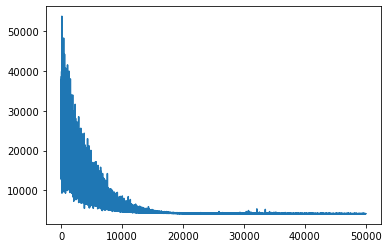

In [48]:
#ELBO Plot - nice convergence
plt.plot(approx3.hist);

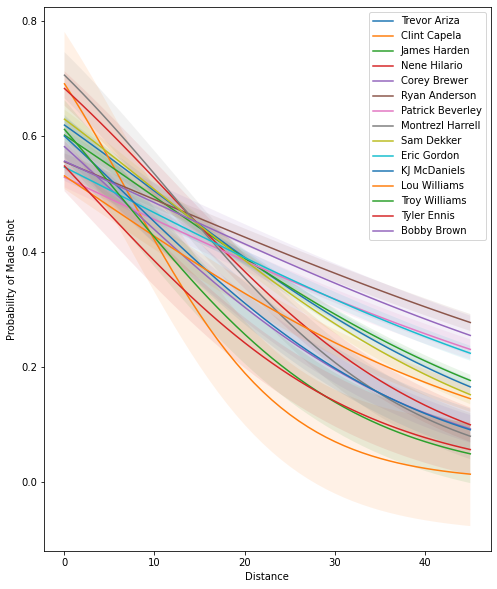

In [49]:
xvals = np.arange(min(distance), max(distance))
b = hierarchical_trace['a'].mean(axis=0)
m = hierarchical_trace['b'].mean(axis=0)
sd = hierarchical_trace['b'].std(axis=0)
plt.figure(figsize = (8,10))
count = -1
for bi,mi, sdi in zip(b,m, sd):
    count  += 1
    label = list(player_lookup_train.keys())[list(player_lookup_train.values()).index(count)]
    yvals = logistic(mi*xvals + bi)
    #lowerbound = logistic(mi*xvals + bi - 2*sdi)
    #upperbound = logistic(mi*xvals + bi + 2*sdi)
    plt.plot(xvals, yvals, label = label)
    plt.fill_between(xvals, (yvals-2*sdi), (yvals+2*sdi), alpha=.1)

plt.xlabel("Distance")
plt.ylabel("Probability of Made Shot")
plt.legend() 

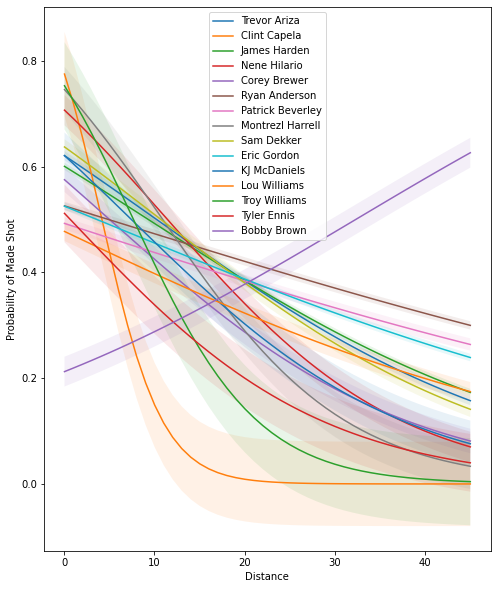

In [50]:
xvals = np.arange(min(distance), max(distance))
b = hierarchical_fit['a'].mean(axis=0)
m = hierarchical_fit['b'].mean(axis=0)
sd = hierarchical_fit['b'].std(axis=0)
plt.figure(figsize = (8,10))
count = -1
for bi,mi, sdi in zip(b,m, sd):
    count  += 1
    label = list(player_lookup_train.keys())[list(player_lookup_train.values()).index(count)]
    yvals = logistic(mi*xvals + bi)
    #lowerbound = logistic(mi*xvals + bi - 2*sdi)
    #upperbound = logistic(mi*xvals + bi + 2*sdi)
    plt.plot(xvals, yvals, label = label)
    plt.fill_between(xvals, (yvals-2*sdi), (yvals+2*sdi), alpha=.1)

plt.xlabel("Distance")
plt.ylabel("Probability of Made Shot")
plt.legend() 

<Figure size 432x1296 with 0 Axes>

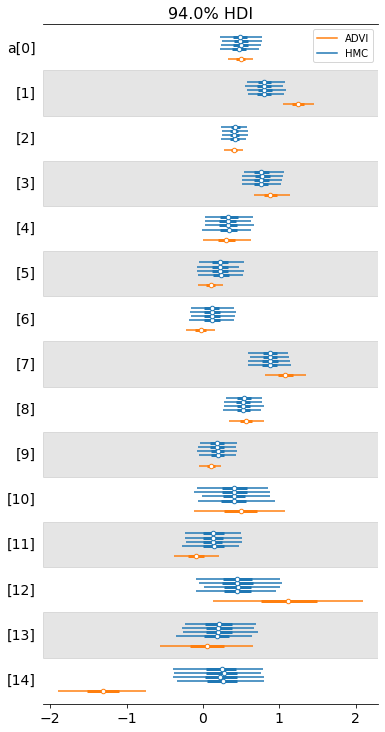

In [51]:
with hierarchical_model:
    plt.figure(figsize=(6,18))
    pm.plot_forest([hierarchical_trace, hierarchical_fit], 
                   model_names = ['HMC', 'ADVI'], var_names = 'a')

<Figure size 432x1296 with 0 Axes>

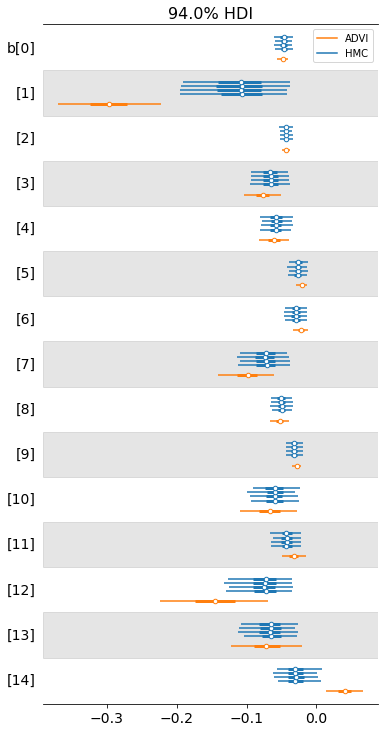

In [52]:
with hierarchical_model:
    plt.figure(figsize=(6,18))
    pm.plot_forest([hierarchical_trace, hierarchical_fit], 
                   model_names = ['HMC', 'ADVI'], var_names = 'b')

In [53]:
# set up test values
uniq_players_test = test_df['shoot player'].unique()
players_test = len(uniq_players_test)
player_test = np.array(test_df['shoot player'])
player_lookup_test = dict(zip(uniq_players_test , range(len(uniq_players_test))))
player_test = test_df['player'] = test_df['shoot player'].replace(player_lookup_test).values

## Predictions

### Pooled

In [54]:
#Reference = https://juanitorduz.github.io/glm_pymc3/

# Update data reference.
pm.set_data({"distance_data": test_distance, 'observed_data':test_made_shot}, model=pooled_model)
# Generate posterior samples.
ppc_test_HMC = pm.sample_posterior_predictive(pooled_trace, model=pooled_model, samples=1000)
ppc_test_ADVI = pm.sample_posterior_predictive(pooling_fit, model=pooled_model, samples=1000)

thresh = .5


p_test_pred_HMC = ppc_test_HMC["y"].mean(axis=0)
y_test_pred_HMC = (p_test_pred_HMC >= thresh).astype("int")


print('HMC Recults for pooled model:')
print(f"accuracy = {accuracy_score(y_true=test_df['made_shot'], y_pred=y_test_pred_HMC): 0.3f}")
print(f"recall = {recall_score(y_true=test_df['made_shot'], y_pred=y_test_pred_HMC): 0.3f}")
print(f"precision = {precision_score(y_true=test_df['made_shot'], y_pred=y_test_pred_HMC): 0.3f}")
print('Confusion Matrix:')
print(confusion_matrix(y_true = test_df['made_shot'], y_pred = y_test_pred_HMC ))

print('\n')
print('\n')

print('ADVI Recults for pooled model:')

p_test_pred_ADVI = ppc_test_ADVI["y"].mean(axis=0)
y_test_pred_ADVI = (p_test_pred_ADVI >= thresh).astype("int")

print(f"accuracy = {accuracy_score(y_true=test_df['made_shot'], y_pred=y_test_pred_ADVI): 0.3f}")
print(f"recall = {recall_score(y_true=test_df['made_shot'], y_pred=y_test_pred_ADVI): 0.3f}")
print(f"precision = {precision_score(y_true=test_df['made_shot'], y_pred=y_test_pred_ADVI): 0.3f}")
print('Confusion Matrix:')
print(confusion_matrix(y_true = test_df['made_shot'], y_pred = y_test_pred_ADVI ))

/Users/mackenzyeleroy/opt/anaconda3/lib/python3.8/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


HMC Recults for pooled model:
accuracy =  0.616
recall =  0.559
precision =  0.605
Confusion Matrix:
[[350 174]
 [210 266]]




ADVI Recults for pooled model:
accuracy =  0.616
recall =  0.559
precision =  0.605
Confusion Matrix:
[[350 174]
 [210 266]]


### Unpooled

In [55]:
# Update data reference.
pm.set_data({"distance_data": test_distance, 'observed_data':test_made_shot, 'player': player_test}, model=unpooled_model)
# Generate posterior samples.
ppc_test_HMC = pm.sample_posterior_predictive(unpooled_trace, model=unpooled_model, samples=1000)
ppc_test_ADVI = pm.sample_posterior_predictive(unpooled_fit, model=unpooled_model, samples=1000)



thresh = .5


p_test_pred_HMC = ppc_test_HMC["y"].mean(axis=0)
y_test_pred_HMC = (p_test_pred_HMC >= thresh).astype("int")


print('HMC Recults for unpooled model:')
print(f"accuracy = {accuracy_score(y_true=test_df['made_shot'], y_pred=y_test_pred_HMC): 0.3f}")
print(f"recall = {recall_score(y_true=test_df['made_shot'], y_pred=y_test_pred_HMC): 0.3f}")
print(f"precision = {precision_score(y_true=test_df['made_shot'], y_pred=y_test_pred_HMC): 0.3f}")
print('Confusion Matrix:')
print(confusion_matrix(y_true = test_df['made_shot'], y_pred = y_test_pred_HMC ))

print('\n')
print('\n')

print('ADVI Recults for unpooled model:')

p_test_pred_ADVI = ppc_test_ADVI["y"].mean(axis=0)
y_test_pred_ADVI = (p_test_pred_ADVI >= thresh).astype("int")

print(f"accuracy = {accuracy_score(y_true=test_df['made_shot'], y_pred=y_test_pred_ADVI): 0.3f}")
print(f"recall = {recall_score(y_true=test_df['made_shot'], y_pred=y_test_pred_ADVI): 0.3f}")
print(f"precision = {precision_score(y_true=test_df['made_shot'], y_pred=y_test_pred_ADVI): 0.3f}")
print('Confusion Matrix:')
print(confusion_matrix(y_true = test_df['made_shot'], y_pred = y_test_pred_ADVI ))




/Users/mackenzyeleroy/opt/anaconda3/lib/python3.8/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


HMC Recults for unpooled model:
accuracy =  0.627
recall =  0.481
precision =  0.645
Confusion Matrix:
[[398 126]
 [247 229]]




ADVI Recults for unpooled model:
accuracy =  0.627
recall =  0.483
precision =  0.644
Confusion Matrix:
[[397 127]
 [246 230]]


### Hierarchical 

In [56]:
# Update data reference.
pm.set_data({"distance_data": test_distance, 'observed_data':test_made_shot, 'player': player_test}, model=hierarchical_model)
# Generate posterior samples.
ppc_test_HMC = pm.sample_posterior_predictive(hierarchical_trace, model=hierarchical_model, samples=1000)
ppc_test_ADVI = pm.sample_posterior_predictive(hierarchical_fit, model=hierarchical_model, samples=1000)



thresh = .5


p_test_pred_HMC = ppc_test_HMC["y"].mean(axis=0)
y_test_pred_HMC = (p_test_pred_HMC >= thresh).astype("int")


print('HMC Recults for hierarchical model:')
print(f"accuracy = {accuracy_score(y_true=test_df['made_shot'], y_pred=y_test_pred_HMC): 0.3f}")
print(f"recall = {recall_score(y_true=test_df['made_shot'], y_pred=y_test_pred_HMC): 0.3f}")
print(f"precision = {precision_score(y_true=test_df['made_shot'], y_pred=y_test_pred_HMC): 0.3f}")
print('Confusion Matrix:')
print(confusion_matrix(y_true = test_df['made_shot'], y_pred = y_test_pred_HMC ))

print('\n')
print('\n')

print('ADVI Recults for hierarchical model:')

p_test_pred_ADVI = ppc_test_ADVI["y"].mean(axis=0)
y_test_pred_ADVI = (p_test_pred_ADVI >= thresh).astype("int")

print(f"accuracy = {accuracy_score(y_true=test_df['made_shot'], y_pred=y_test_pred_ADVI): 0.3f}")
print(f"recall = {recall_score(y_true=test_df['made_shot'], y_pred=y_test_pred_ADVI): 0.3f}")
print(f"precision = {precision_score(y_true=test_df['made_shot'], y_pred=y_test_pred_ADVI): 0.3f}")
print('Confusion Matrix:')
print(confusion_matrix(y_true = test_df['made_shot'], y_pred = y_test_pred_ADVI ))




/Users/mackenzyeleroy/opt/anaconda3/lib/python3.8/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


HMC Recults for hierarchical model:
accuracy =  0.630
recall =  0.532
precision =  0.632
Confusion Matrix:
[[377 147]
 [223 253]]




ADVI Recults for hierarchical model:
accuracy =  0.622
recall =  0.473
precision =  0.639
Confusion Matrix:
[[397 127]
 [251 225]]


In [57]:
#Overall shooting percentage (baseline to beat = 1 - shooting percentage)
df['made_shot'].sum()/len(df)

0.4625908507909363